In [3]:
import pyspark

In [4]:
sc = pyspark.SparkContext.getOrCreate()

# Example (Word Count)

In [5]:
rdd = sc.textFile("big-data/example.txt") # Load the text file into pyspark

word_counts_rdd = (
    rdd
        .flatMap(lambda line: line.split(" ")) # Map a single value (line) to multiple values (words)
        .map(lambda word: (word, 1))
        .reduceByKey(lambda a,b: a + b) # Group all K,V pairs by key and sum up the counts
)

# Spark is lazy. The transformations are only computed as soon as we call `collect`
print(sorted(word_counts_rdd.collect()))

[('', 23), ('At', 12), ('Consetetur', 1), ('Duis', 6), ('Lorem', 26), ('Nam', 2), ('Stet', 12), ('Ut', 4), ('accumsan', 4), ('accusam', 12), ('ad', 4), ('adipiscing', 4), ('aliquam', 4), ('aliquip', 4), ('aliquyam', 12), ('amet,', 15), ('amet.', 11), ('assum.', 2), ('at', 4), ('augue', 4), ('autem', 6), ('blandit', 4), ('clita', 12), ('commodo', 4), ('congue', 2), ('consectetuer', 4), ('consequat,', 5), ('consequat.', 4), ('consetetur', 11), ('cum', 2), ('delenit', 4), ('diam', 27), ('dignissim', 4), ('dolor', 32), ('dolore', 25), ('dolores', 12), ('doming', 2), ('duis', 4), ('duo', 12), ('ea', 16), ('eirmod', 12), ('eleifend', 2), ('elit,', 4), ('elitr,', 12), ('enim', 4), ('eos', 12), ('erat', 4), ('erat,', 11), ('erat.', 1), ('eros', 4), ('esse', 5), ('est', 11), ('et', 56), ('eu', 5), ('euismod', 4), ('eum', 6), ('ex', 4), ('exerci', 4), ('facer', 2), ('facilisi.', 4), ('facilisis', 4), ('facilisis.', 1), ('feugait', 4), ('feugiat', 5), ('gubergren,', 12), ('hendrerit', 5), ('id', 

In [6]:
from pm4py import view_dfg, save_vis_dfg

# DFG Discovery

## a)

### Input
Each input record is a CSV line (no header) describing an event
$$
(c,a,t) \in C \times A \times T,
$$
and the raw input to MapReduce is
$$
K \times V = \mathbb{N}_0 \times S
$$
(line number, line string).

---

### Job 1: Group events by case and extract directly-follows pairs

**Map\(_1\) signature**
$$
\text{map}_1 : \mathbb{N}_0 \times S \rightarrow \mathcal{P}\!\left(C \times (A \times T)\right)
$$

**Map\(_1\) output**
$$
\text{map}_1(n,\text{line}) = \{(c,(a,t))\}.
$$

**Reduce\(_1\) signature**
$$
\text{reduce}_1 : C \times \mathcal{P}(A \times T) \rightarrow \mathcal{P}\!\left((A \times A) \times \mathbb{N}_0\right)
$$

**Reduce\(_1\) output (conceptually)**  
Sort events of case \(c\) by timestamp to get \(a_{(1)},\dots,a_{(m)}\), then emit
$$
\text{reduce}_1(c,\{(a_i,t_i)\})=\{((a_{(i)},a_{(i+1)}),1)\mid i=1,\dots,m-1\}.
$$

---

### Job 2: Aggregate counts of directly-follows pairs

**Map\(_2\) signature**
$$
\text{map}_2 : (A \times A) \times \mathbb{N}_0 \rightarrow \mathcal{P}\!\left((A \times A) \times \mathbb{N}_0\right)
$$

**Map\(_2\) output**
$$
\text{map}_2((a,b),1)=\{((a,b),1)\}.
$$

**Reduce\(_2\) signature**
$$
\text{reduce}_2 : (A \times A) \times \mathcal{P}(\mathbb{N}_0) \rightarrow \mathcal{P}\!\left((A \times A) \times \mathbb{N}_0\right)
$$

**Reduce\(_2\) output**
$$
\text{reduce}_2((a,b),\{1,\dots,1\})=\{((a,b),\sum 1)\}.
$$

---

### Output
The final output is the DFG edge multiset
$$
\{((a,b),\text{count}_{a,b}) \mid a,b \in A\}.
$$

### (b)

In [7]:
from datetime import datetime
# 1) read lines
rdd = sc.textFile("big-data/event_log.csv.gz")

def parse_line(line: str):
    # CSV has no header and columns: CaseID, Activity, Timestamp, Resource
    parts = line.split(",")
    case_id = parts[0].strip()
    activity = parts[1].strip()
    ts_raw = parts[2].strip()
    # Unix timestamp (seconds, possibly float)
    ts = datetime.fromtimestamp(float(ts_raw))
    return (case_id, ts, activity)

events = rdd.map(parse_line)  # 2) parse

# 3) key by case
by_case = events.map(lambda x: (x[0], (x[1], x[2])))

# 4) group events per case
grouped = by_case.groupByKey()

# 5) sort per case
sorted_per_case = grouped.mapValues(lambda it: sorted(list(it), key=lambda p: p[0]))
# now values look like: [(t1,a1),(t2,a2),...]

# 6) extract directly-follows pairs
def to_pairs(case_and_seq):
    _, seq = case_and_seq
    acts = [a for (_, a) in seq]
    return [((acts[i], acts[i+1]), 1) for i in range(len(acts) - 1)]

pairs = sorted_per_case.flatMap(to_pairs)

# 7) count edges
dfg_counts_rdd = pairs.reduceByKey(lambda x, y: x + y)

# Collect to Python dict for pm4py: {(a,b): count, ...}
dfg = dict(dfg_counts_rdd.collect())

In [8]:
# Start activities per case: first activity in sorted sequence
start_counts = (sorted_per_case
    .map(lambda kv: (kv[1][0][1], 1))   # kv[1][0] = (t_first, a_first)
    .reduceByKey(lambda x, y: x + y)
    .collectAsMap()
)

# End activities per case: last activity in sorted sequence
end_counts = (sorted_per_case
    .map(lambda kv: (kv[1][-1][1], 1))  # (t_last, a_last)
    .reduceByKey(lambda x, y: x + y)
    .collectAsMap()
)

# Save a figure file (png)
save_vis_dfg(dfg, start_activities=start_counts, end_activities=end_counts, file_path="dfg.png")
print("Saved to dfg.png")

Saved to dfg.png


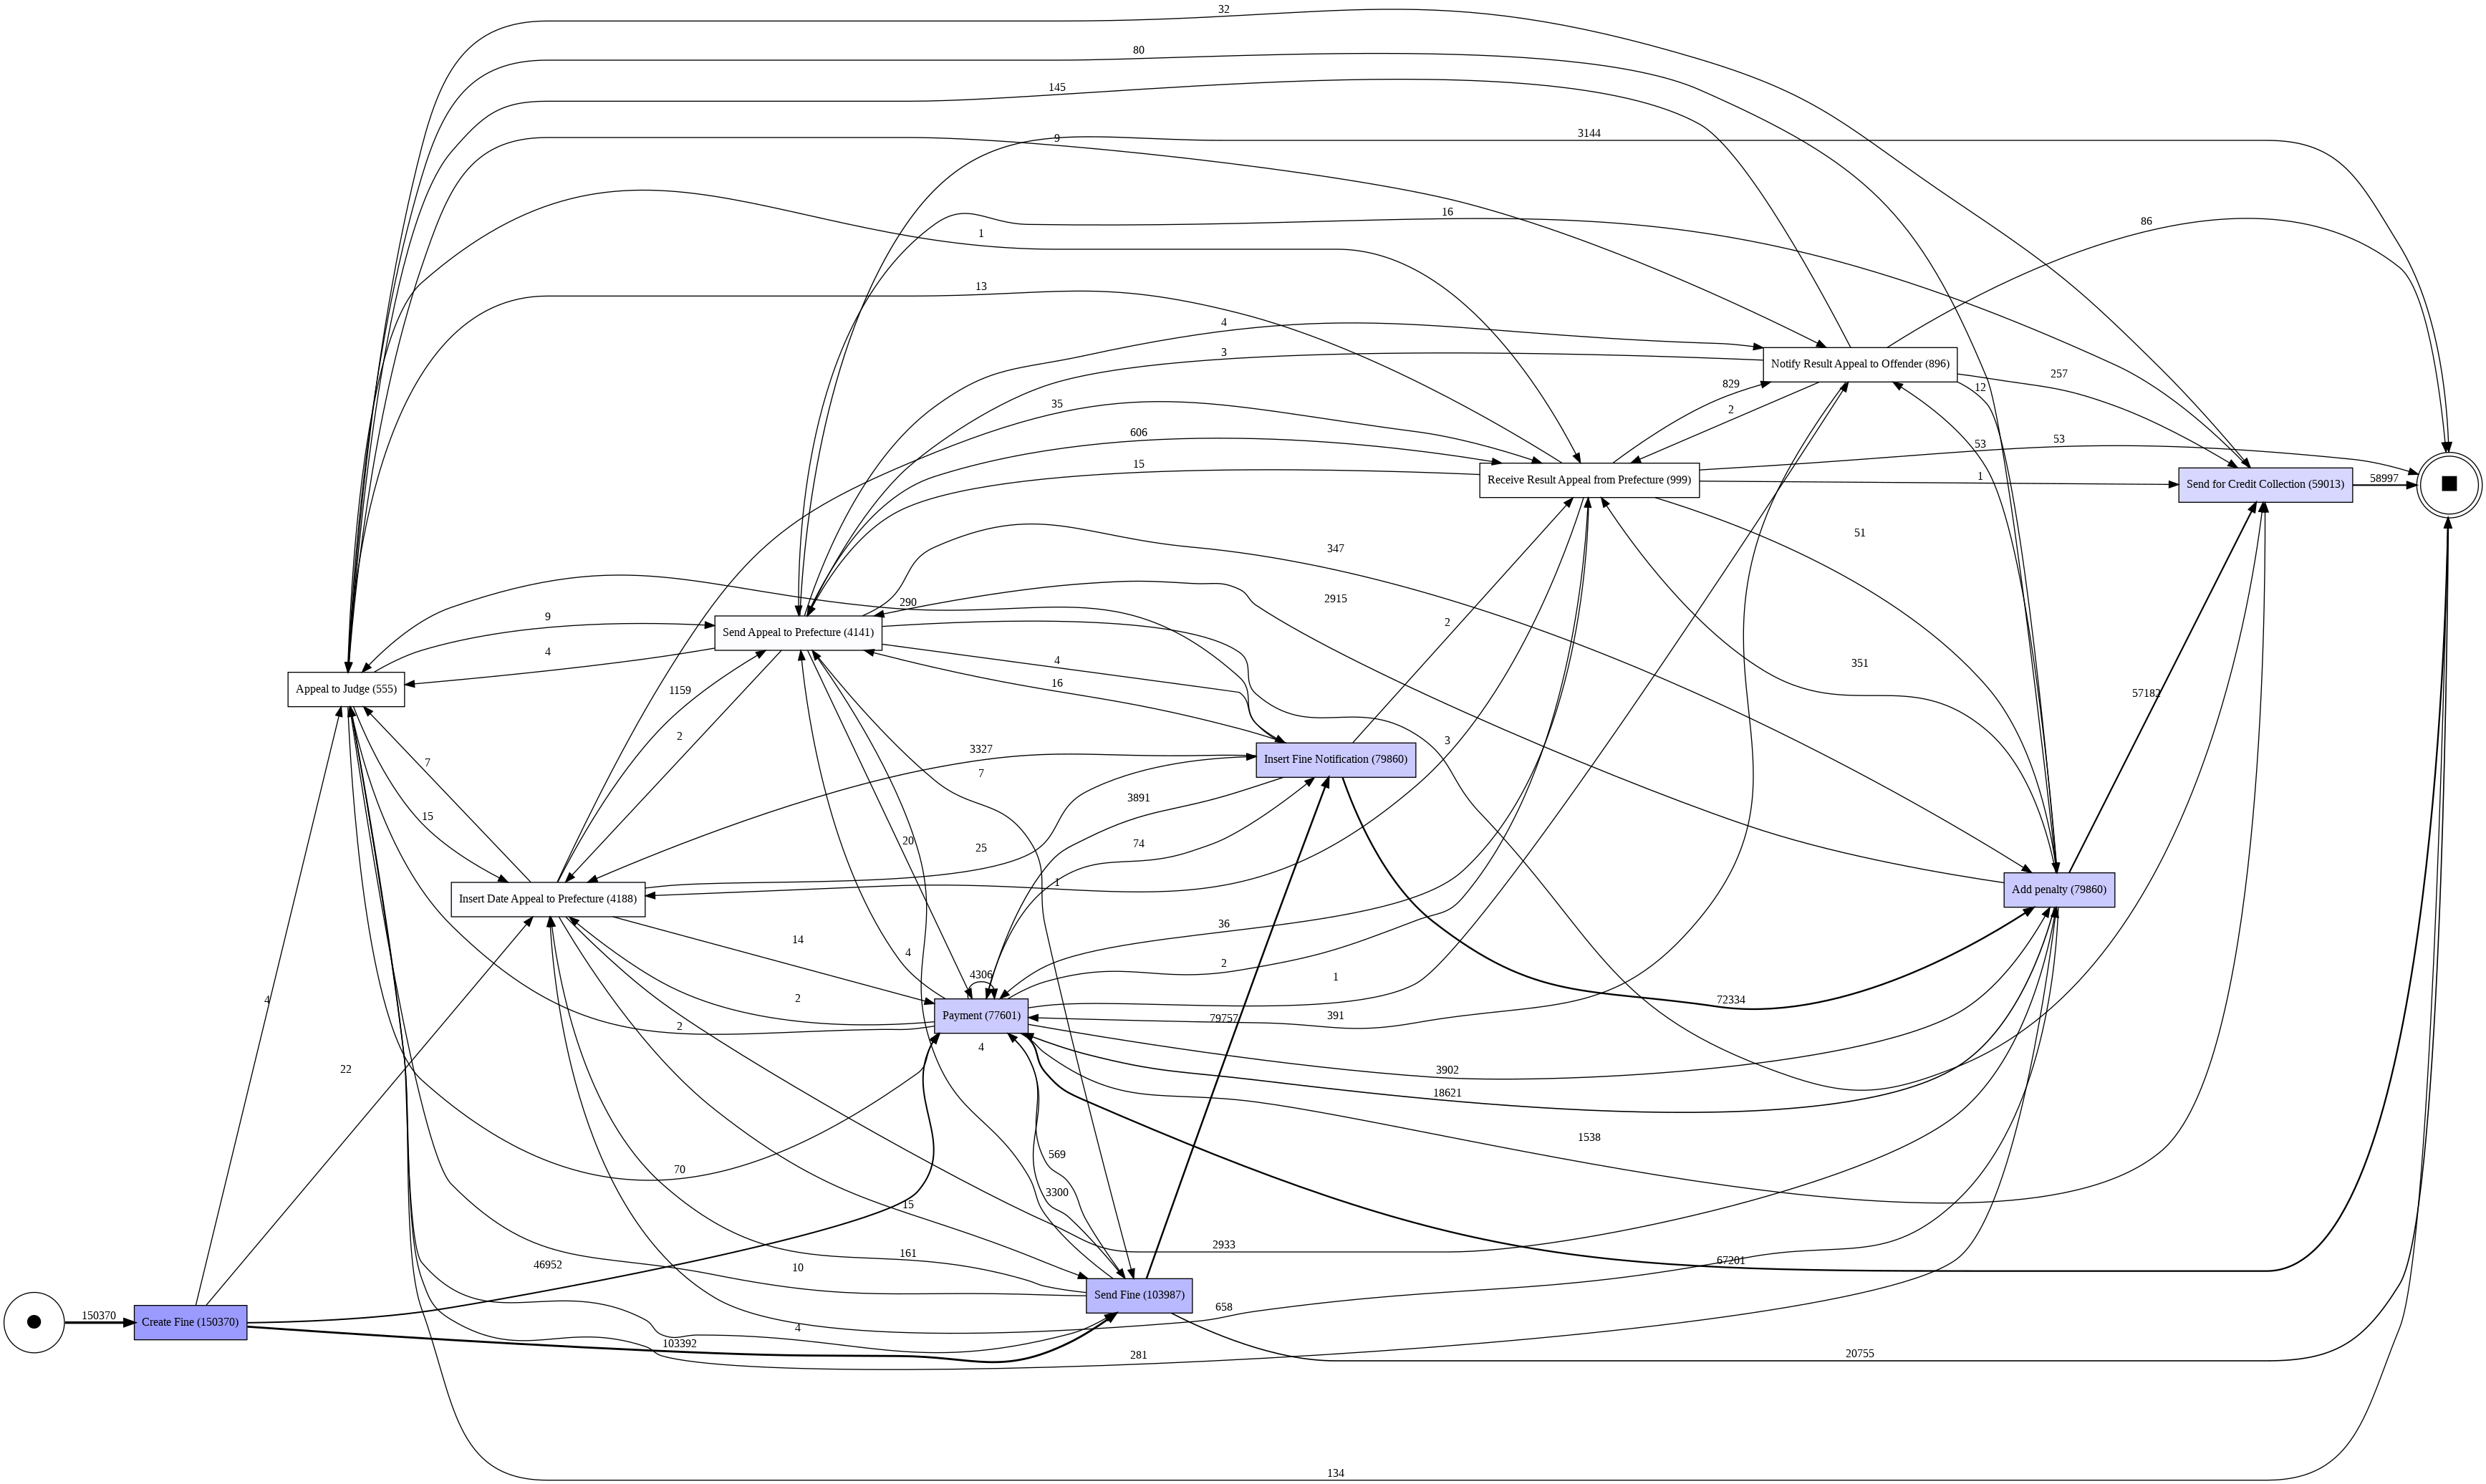

In [9]:
from IPython.display import Image, display
display(Image("dfg.png"))

## (c)

After computing the directly-follows frequencies in the reduce phase, arcs with a total count smaller than 100 are filtered out. This removes infrequent behavior while preserving the dominant process structure.

In [10]:
filtered_dfg_rdd = dfg_counts_rdd.filter(lambda kv: kv[1] >= 100)
filtered_dfg = dict(filtered_dfg_rdd.collect())

In [11]:
save_vis_dfg(
    filtered_dfg,
    start_activities=start_counts,
    end_activities=end_counts,
    file_path="dfg_filtered_100.png"
)

''

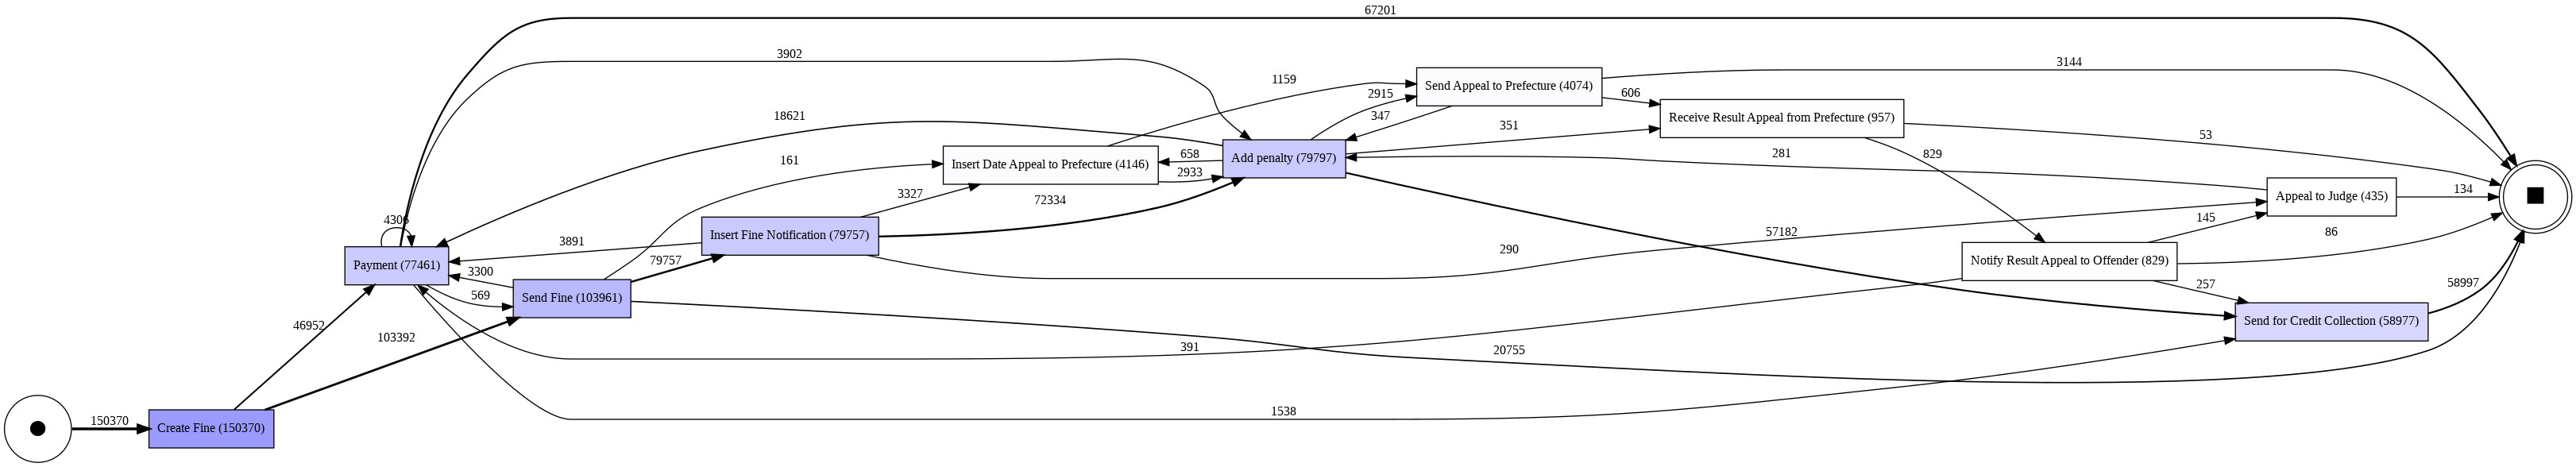

In [12]:
display(Image("dfg_filtered_100.png"))

# (d)

In [13]:
def parse_line(line):
    parts = line.split(",")
    activity = parts[1].strip()
    resource = parts[3].strip()   # may be "MISSING"
    return (activity, resource)

events = rdd.map(parse_line)

In [14]:
# Count (activity, resource) occurrences
activity_resource_counts = (
    events
    .map(lambda x: ((x[0], x[1]), 1))     # ((activity, resource), 1)
    .reduceByKey(lambda x, y: x + y)      # count per (activity, resource)
)

# Re-key by activity
by_activity = activity_resource_counts.map(
    lambda x: (x[0][0], (x[0][1], x[1]))
) # (activity, (resource, count))

most_common_resource = by_activity.reduceByKey(
    lambda r1, r2: r1 if r1[1] >= r2[1] else r2
)

result = most_common_resource.collect()

for activity, (resource, count) in sorted(result):
    print(f"{activity}: {resource} ({count})")

Add penalty: MISSING (79860)
Appeal to Judge: R-0 (555)
Create Fine: R-538 (8608)
Insert Date Appeal to Prefecture: MISSING (4188)
Insert Fine Notification: MISSING (79860)
Notify Result Appeal to Offender: MISSING (896)
Payment: MISSING (77601)
Receive Result Appeal from Prefecture: MISSING (999)
Send Appeal to Prefecture: MISSING (4141)
Send Fine: MISSING (103987)
Send for Credit Collection: MISSING (59013)


**map1**
Parses each line and extracts the activity and resource.

**map2**
Creates key–value pairs of the form ((activity, resource), 1).

**reduceByKey1**
Aggregates counts to compute how often each resource executes a given activity.

**map3**
Reorganizes the data by activity, producing (activity, (resource, count)).

**reduceByKey2**
Selects, for each activity, the resource with the highest execution count.